In [21]:
import sqlite3
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## DATA CLEANING

### Clean the weather date

#### We used the weather data and average temperature and precipitation by date.

In [22]:
weather_mdw = pd.read_csv("MDW.csv", index_col = "Date", parse_dates = ["Date"],
                          names = ["Date", "Temperature", "Precipitation"])
weather_mdw.head()
weather_mdw = weather_mdw[["Temperature", "Precipitation"]].resample("1D").mean()
weather_mdw.to_csv("weather.csv")

### Create weather table in sqlite3

#### We create an empty database, and then create an empty table named weather and insert the records.

In [23]:
conn = sqlite3.connect('database.db')
print("Opened database successfully")
c = conn.cursor()
c.execute("DROP TABLE IF EXISTS WEATHER;")
c.execute('''CREATE TABLE IF NOT EXISTS WEATHER
       (DATE DATE PRIMARY KEY NOT NULL,
       TEMPERATURE REAL NOT NULL,
       PRECIPITATION REAL NOT NULL)''')
print("Table created successfully")
conn.commit()
conn.close()

Opened database successfully
Table created successfully


### Insert weather records

In [24]:
conn = sqlite3.connect('database.db')
c = conn.cursor()
print("Opened database successfully")
mdw_csv = open("weather.csv", "r")
mdw_csv.readline()
for line in mdw_csv:
    line = line.strip()
    arr = line.split(",")
    try:
        c.execute("INSERT INTO  WEATHER(DATE,TEMPERATURE,PRECIPITATION) VALUES (?,?,?)",(arr[0], arr[1], arr[2]));
    except Exception as e:
        pass
conn.commit()
print("Records created successfully")
conn.close()

Opened database successfully
Records created successfully


### Clean the red light camera violation data

#### As we have already transformed the address of the cameras to zip-codes using ArcMAP, we create an table named violations and import the data from the output.

In [25]:
vdf_csv = open("Export_Output.csv", "r")
output = open("violation.csv", "w")
vdf_csv.readline()
for line in vdf_csv:
    line = line.strip()
    arr = line.split(",")
    dt = datetime.strptime(arr[3],"%m/%d/%Y %H:%M")
    arr[3] = dt.strftime("%Y-%m-%d")
    output.write(",".join(arr) + "\n")
output.close()
print("done")

done


### Create red light camera violation table in sqlite3

#### We create an empty table named violation and insert the records.

In [26]:
conn = sqlite3.connect('database.db')
print("Opened database successfully")
c = conn.cursor()
c.execute("DROP TABLE IF EXISTS VIOLATION;")
c.execute('''CREATE TABLE VIOLATION
       (CAMERAID INTEGER NOT NULL,
       DATE DATE NOT NULL,
       INTER TEXT,
       ADDRESS TEXT,
       VIOLATION INTEGER,
       LATITUDE REAL,
       LONGITUDE REAL,
       ZIPCODE INTEGER NOT NULL,
       PRIMARY KEY(CAMERAID, DATE)
       )''')
print("Table created successfully")
conn.commit()
conn.close()

Opened database successfully
Table created successfully


### Insert red light camera violation records

In [27]:
conn = sqlite3.connect('database.db')
c = conn.cursor()
print("Opened database successfully")
mdw_csv = open("violation.csv", "r")
mdw_csv.readline()
for line in mdw_csv:
    line = line.strip()
    arr = line.split(",")
    try:
        c.execute("INSERT INTO  VIOLATION(CAMERAID, DATE,INTER, ADDRESS, VIOLATION, LATITUDE, LATITUDE, ZIPCODE) \
                  VALUES (?,?,?,?,?,?,?,?)",(arr[1], arr[3], arr[0], arr[2],arr[4], arr[5], arr[6], arr[7]));
    except Exception as e:
        pass
conn.commit()
print("Records created successfully")
conn.close()

Opened database successfully
Records created successfully


## Describe the data: Basic information about red light camera violation

### The relationship between zipcode and average red light camera violation

#### We want to know the average number of red light camera violation for each zip code area during the past three years. We retrive zipcode and average red light camera violation from SQL, and then create a dataFrame to plot the table.

Opened database successfully
Operation done successfully


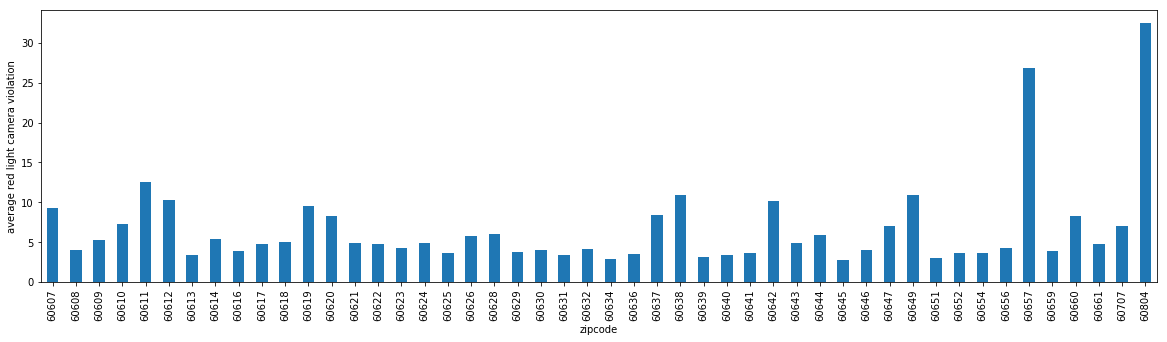

In [28]:
conn = sqlite3.connect('database.db')
c = conn.cursor()
print("Opened database successfully")
cursor = c.execute("select zipcode, avg(violation) as violation \
from weather as w join violation as v on w.DATE=v.DATE group by zipcode order by zipcode;")

zipcodes = []
violations = []


for row in cursor:
    zipcodes.append(row[0])
    violations.append(float(row[1]))
   
print("Operation done successfully")

conn.close()

d={'zipcode': zipcodes, 'violation': violations}
df=pd.DataFrame(data=d)

ax = df.set_index("zipcode")["violation"].plot(kind='bar', figsize = (20, 5))
ax.set_ylabel("average red light camera violation")


### The relationship between the number of camera and average red light camera violation

#### We want to know the average number of red light camera violation each camera recorded during the past three years. We retrive cameraid and average red light camera violation from SQL, and then create a dataFrame to plot the table. We drop the camera "8304" and "8313", as their ids are too far away from others.

Opened database successfully
Operation done successfully


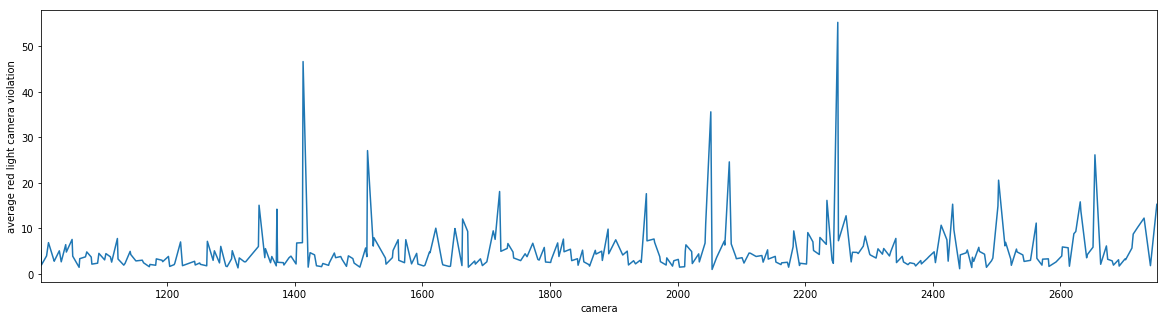

In [29]:
conn = sqlite3.connect('database.db')
c = conn.cursor()
print("Opened database successfully")

cursor = c.execute("select cameraid, avg(violation) as camera \
from weather as w join violation as v on w.DATE=v.DATE where cameraid<=2800 and cameraid>=1000 group by cameraid order by cameraid;")

cameras = []
violations = []


for row in cursor:
    cameras.append(row[0])
    violations.append(float(row[1]))
   
print("Operation done successfully")

conn.close()

d={'camera': cameras, 'violation': violations}
df=pd.DataFrame(data=d)

ax = df.set_index("camera")["violation"].plot(figsize = (20, 5))
ax.set_ylabel("average red light camera violation")

## General Analysis: Holidays and Particular day

### Christmas day and red light camera violation

#### We want to see if Christmas Eve might have more red light camera violations, so we compare the average violation of Christmas Eve in 2014, 2015 and 2016 with the average violation for the last 3 years.

48 48 48 48


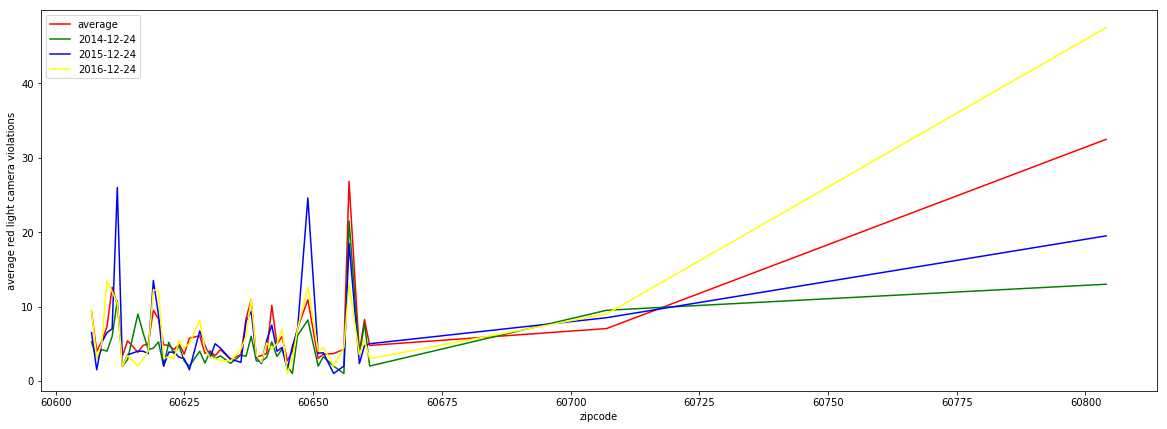

In [30]:
conn = sqlite3.connect('database.db')
c = conn.cursor()

zipcodes = []
violations4=[]
cursor = c.execute("select zipcode, avg(violation) from weather as w join violation as v \
                   on w.DATE=v.DATE group by zipcode order by zipcode;")
for row in cursor:
    zipcodes.append(row[0])
    violations4.append(float(row[1]))
    
violations1 = []
cursor = c.execute("select zipcode, avg(violation) from weather as w join violation as v \
                   on w.DATE=v.DATE where v.DATE='2014-12-24'group by zipcode order by zipcode;")
for row in cursor:
    violations1.append(float(row[1]))

violations2 = []
cursor = c.execute("select zipcode, avg(violation) from weather as w join violation as v \
                   on w.DATE=v.DATE where v.DATE='2015-12-24'  group by zipcode order by zipcode;")
for row in cursor:
    violations2.append(float(row[1]))

violations3 = []
cursor = c.execute("select zipcode, avg(violation) from weather as w join violation as v \
                   on w.DATE=v.DATE where v.DATE='2016-12-24' group by zipcode order by zipcode;")
for row in cursor:
    violations3.append(float(row[1]))    
print(len(violations4),len(violations1), len(violations2),len(violations3))
conn.close()
plt.figure(figsize=(20,7))

plt.xlabel("zipcode")
plt.ylabel("average red light camera violations")
plt.plot(zipcodes, violations4,c='red',label='average')
plt.plot(zipcodes, violations1,c='green',label='2014-12-24')
plt.plot(zipcodes, violations2,c='blue',label='2015-12-24')
plt.plot(zipcodes, violations3,c='yellow',label='2016-12-24')
plt.legend()
plt.show()

### Christmas day and red light camera violation

#### We want to see if Christmas Eve might have more red light camera violations, so we compare the sum of violation of Christmas Eve in 2014, 2015 and 2016 with the rest of days from 12-20 to 12-27.

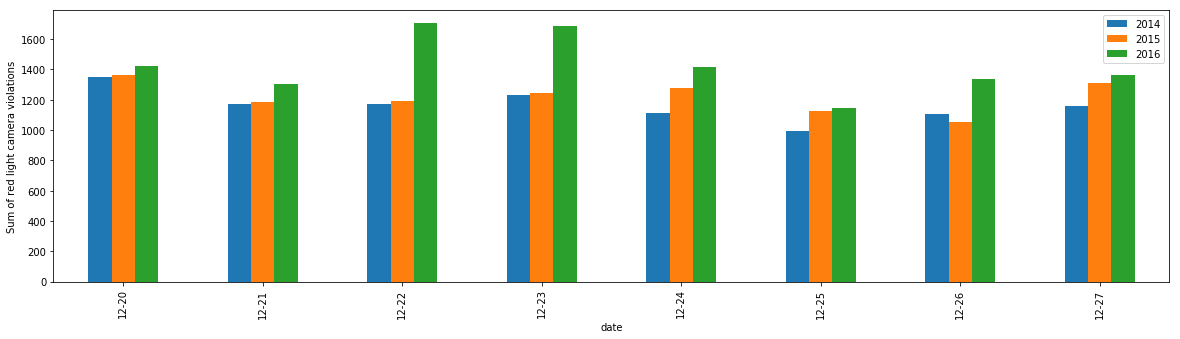

In [31]:
conn = sqlite3.connect('database.db')
c = conn.cursor()

dates = []
violations11=[]
cursor = c.execute("select v.date, sum(violation) from weather as w join violation as v \
                   on w.DATE=v.DATE where v.date>='2014-12-20'and v. date<='2014-12-27' group by v.date order by v.date;")
for row in cursor:
    current_date=datetime.strptime(row[0],"%Y-%m-%d")
    
    dates.append(current_date.strftime("%m-%d"))
    
    violations11.append(float(row[1]))

violations12=[]
cursor = c.execute("select v.date, sum(violation) from weather as w join violation as v \
                   on w.DATE=v.DATE where v.date>='2015-12-20'and v. date<='2015-12-27' group by v.date order by v.date;")
for row in cursor:
    violations12.append(float(row[1]))
    
violations13=[]
cursor = c.execute("select v.date, sum(violation) from weather as w join violation as v \
                   on w.DATE=v.DATE where v.date>='2016-12-20'and v. date<='2016-12-27' group by v.date order by v.date;")
for row in cursor:
    violations13.append(float(row[1]))
    
conn.close()

d={'date': dates,'2014':violations11, '2015':violations12,'2016':violations13}
df=pd.DataFrame(data=d)
df.set_index('date')

ax=df.plot(x='date',kind='bar',figsize=(20,5))
ax.set_ylabel("Sum of red light camera violations")


### The day Cubs win the Championship and red light camera violation

#### We want to see if there are more red light camera violations on the day when Cubs win the Championship. So we compare the average violation on 2016-11-03 with the day before and after that particular date.

48 48 48 48


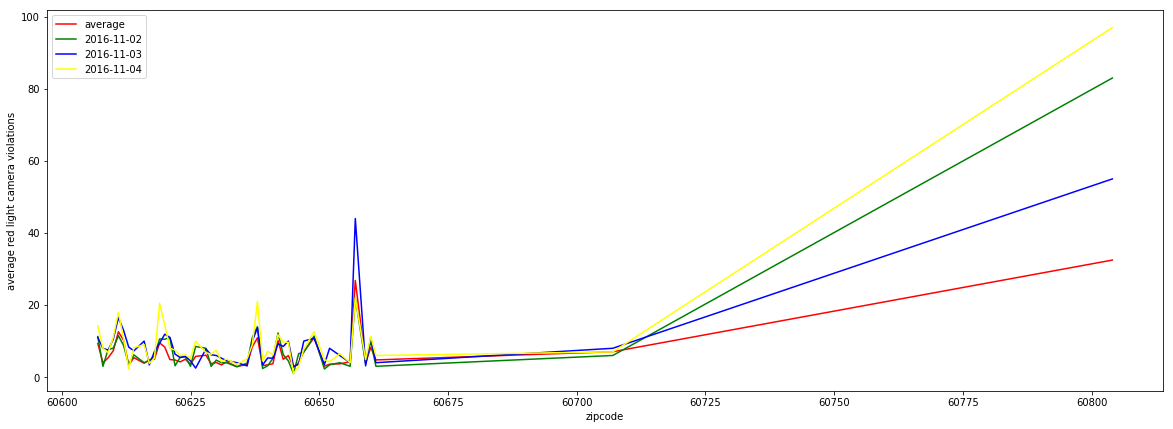

In [32]:
conn = sqlite3.connect('database.db')
c = conn.cursor()

zipcodes = []
violations4=[]
cursor = c.execute("select zipcode, avg(violation) from weather as w join violation as v \
                   on w.DATE=v.DATE group by zipcode order by zipcode;")
for row in cursor:
    zipcodes.append(row[0])
    violations4.append(float(row[1]))
    
violations5 = []
cursor = c.execute("select zipcode, avg(violation) from weather as w join violation as v \
                   on w.DATE=v.DATE where v.DATE='2016-11-02' group by zipcode order by zipcode;")
for row in cursor:
    violations5.append(float(row[1]))

violations6 = []
cursor = c.execute("select zipcode, avg(violation) from weather as w join violation as v \
                   on w.DATE=v.DATE where v.DATE='2016-11-03' group by zipcode order by zipcode;")
for row in cursor:
    violations6.append(float(row[1]))

violations7 = []
cursor = c.execute("select zipcode, avg(violation) from weather as w join violation as v \
                   on w.DATE=v.DATE where v.DATE='2016-11-04' group by zipcode order by zipcode;")
for row in cursor:
    violations7.append(float(row[1]))    
print(len(violations4),len(violations5), len(violations6),len(violations7))

conn.close()
plt.figure(figsize=(20,7))

plt.xlabel("zipcode")
plt.ylabel("average red light camera violations")
plt.plot(zipcodes, violations4,c='red',label='average')
plt.plot(zipcodes, violations5,c='green',label='2016-11-02')
plt.plot(zipcodes, violations6,c='blue',label='2016-11-03')
plt.plot(zipcodes, violations7,c='yellow',label='2016-11-04')

plt.legend()
plt.show()

### The week Cubs win the Championship and red light camera violation

#### We want to see if there are more red light camera violations on the day when Cubs win the Championship. So we compare the sum of violation on 2016-11-03 with the rest of days from 11-01 to 11-07, using three years' data.

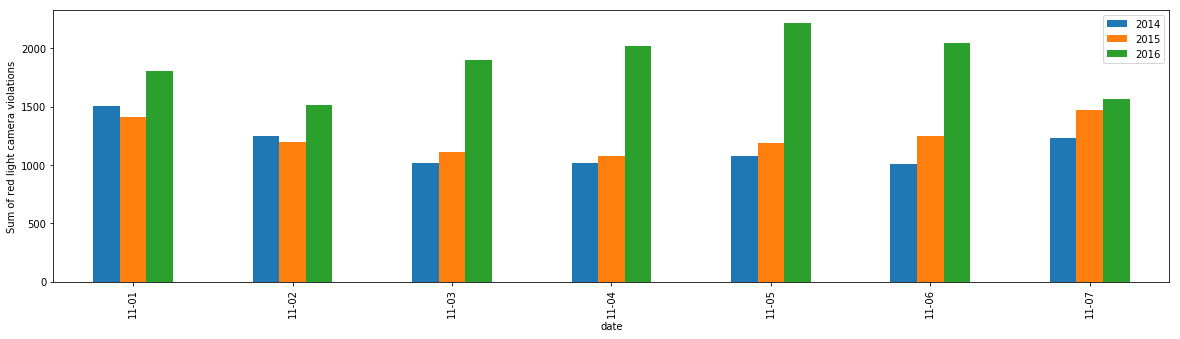

In [33]:
conn = sqlite3.connect('database.db')
c = conn.cursor()

dates = []
violations14=[]
cursor = c.execute("select v.date, sum(violation) from weather as w join violation as v \
                   on w.DATE=v.DATE where v.date>='2014-11-01'and v. date<='2014-11-07' group by v.date order by v.date;")
for row in cursor:
    current_date=datetime.strptime(row[0],"%Y-%m-%d")
    
    dates.append(current_date.strftime("%m-%d"))
    
    violations14.append(float(row[1]))

violations15=[]
cursor = c.execute("select v.date, sum(violation) from weather as w join violation as v \
                   on w.DATE=v.DATE where v.date>='2015-11-01'and v. date<='2015-11-07' group by v.date order by v.date;")
for row in cursor:
    violations15.append(float(row[1]))
    
violations16=[]
cursor = c.execute("select v.date, sum(violation) from weather as w join violation as v \
                   on w.DATE=v.DATE where v.date>='2016-11-01'and v. date<='2016-11-07' group by v.date order by v.date;")
for row in cursor:
    violations16.append(float(row[1]))
    
conn.close()

d={'date': dates,'2014':violations14, '2015':violations15,'2016':violations16}
df=pd.DataFrame(data=d)
df.set_index('date')

ax=df.plot(x='date',kind='bar',figsize=(20,5))
ax.set_ylabel("Sum of red light camera violations")

## General Analysis: Date


### Date and the sum of red light camera violations

#### We want to know the total amount of red light camera violations for the last three years by date, so we retrive date, sum of violation from SQL and plot the table.

Opened database successfully
Operation done successfully


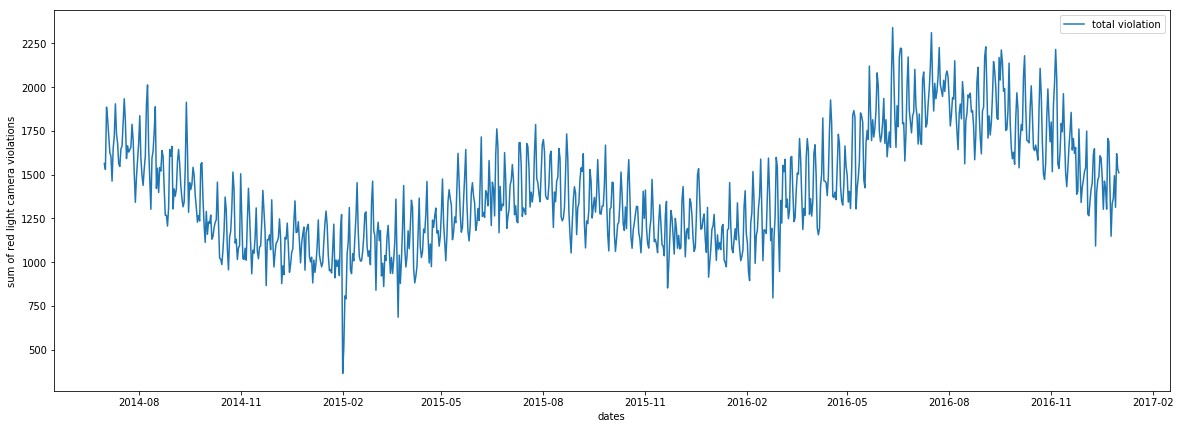

In [35]:
conn = sqlite3.connect('database.db')
c = conn.cursor()
print("Opened database successfully")

cursor = c.execute("select w.DATE, sum(violation) as violation from weather as w join violation as v \
                   on w.DATE=v.DATE group by w.DATE ORDER BY w.DATE;")
dates = []
violations = []
weekdays=[]

for row in cursor:
    current_date=datetime.strptime(row[0],"%Y-%m-%d")
    weekday=current_date.strftime("%w")
    dates.append(current_date)
    weekdays.append(weekday)
    violations.append(float(row[1]))
    
print("Operation done successfully")

conn.close()

plt.figure(figsize=(20,7))

plt.xlabel("dates")
plt.ylabel("sum of red light camera violations")
plt.plot(dates,violations,label='total violation')
plt.legend()
plt.show()

### Day and the sum of red light camera violations

#### We want to know the total amount of red light camera violations for the last three years by day, meaning that we assume that people are more likely to violate the law on Saturday and Sunday. so we retrive date, sum of violation from SQL, transfer date into day, and plot the table.

Opened database successfully
Operation done successfully


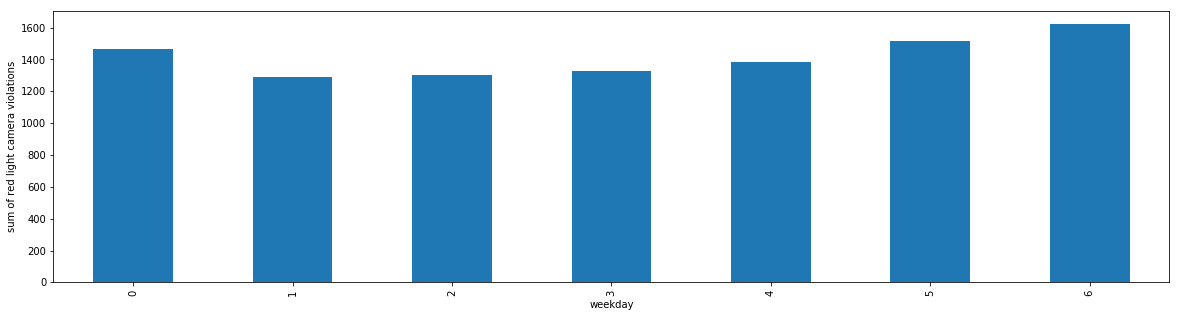

In [37]:
conn = sqlite3.connect('database.db')
c = conn.cursor()
print("Opened database successfully")
cursor = c.execute("select w.DATE, sum(violation) as violation from weather as w join violation as v \
                   on w.DATE=v.DATE group by w.DATE ORDER BY w.DATE")

violations = []
weekdays=[]

for row in cursor:
    current_date=datetime.strptime(row[0],"%Y-%m-%d")
    weekday=current_date.strftime("%w")
    
    weekdays.append(weekday)
    
    violations.append(float(row[1]))
    
print("Operation done successfully")

conn.close()

d={'weekday': weekdays,'violation': violations}
df=pd.DataFrame(data=d)
df

df_weekday=df.groupby(['weekday'])['violation'].mean()
ax=df_weekday.plot(kind='bar', figsize = (20, 5))

ax.set_ylabel("sum of red light camera violations");





### Month and the sum of red light camera violations

#### We want to know the total amount of red light camera violations for the last three years by month. so we retrive date, sum of violation from SQL, transfer date into month, and plot the table.

Opened database successfully
Operation done successfully


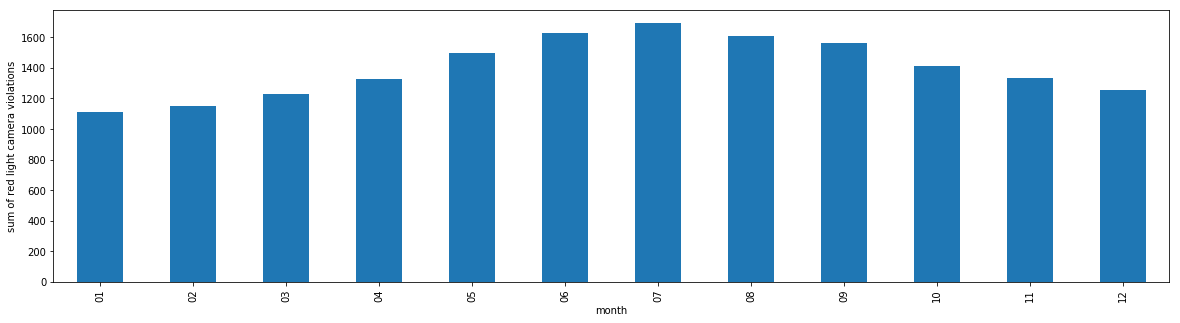

In [39]:
conn = sqlite3.connect('database.db')
c = conn.cursor()
print("Opened database successfully")
cursor = c.execute("select w.DATE, sum(violation) as violation from weather as w join violation as v \
                   on w.DATE=v.DATE group by w.DATE ORDER BY w.DATE")

violations = []
months=[]

for row in cursor:
    current_date=datetime.strptime(row[0],"%Y-%m-%d")
    month=current_date.strftime("%m")
    months.append(month)
    violations.append(float(row[1]))
    
print("Operation done successfully")
conn.close()

d={'weekday': weekdays,'month':months, 'violation': violations}
df=pd.DataFrame(data=d)


df_month=df.groupby(['month'])['violation'].mean()
ax= df_month.plot(kind='bar', figsize = (20, 5))
ax.set_ylabel("sum of red light camera violations");

### Date and the number of red light camera violations

#### We want to know the total number of red light cameras for the last three years by date. so we retrive date, count cameraid from SQL, and plot the table.

Opened database successfully
Operation done successfully


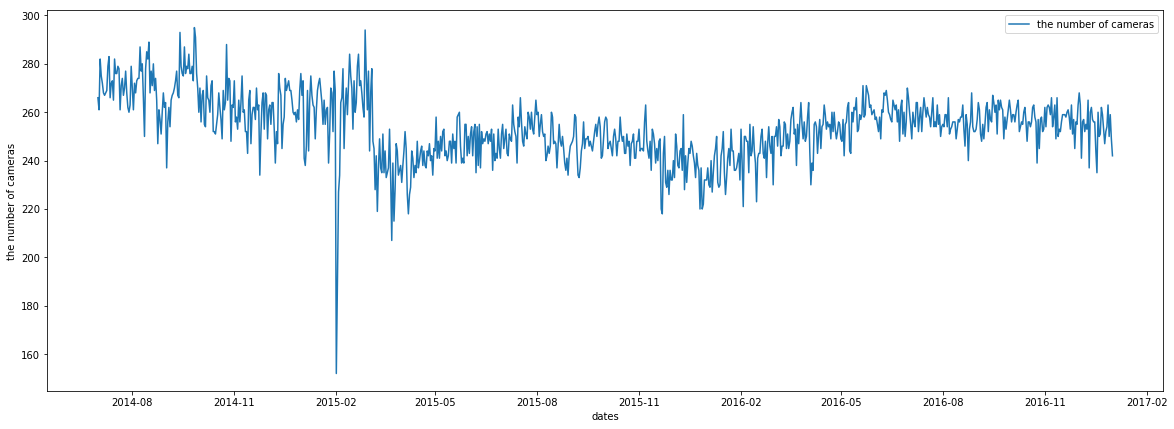

In [40]:
conn = sqlite3.connect('database.db')
c = conn.cursor()
print("Opened database successfully")
cursor = c.execute("select w.DATE, count(cameraid) as camera from weather as w join violation as v \
                   on w.DATE=v.DATE group by w.DATE ORDER BY w.DATE")
dates = []
cameras = []
for row in cursor:
    current_date=datetime.strptime(row[0],"%Y-%m-%d")
    dates.append(current_date)
    cameras.append(float(row[1]))
print("Operation done successfully")
conn.close()

plt.figure(figsize=(20,7))

plt.xlabel("dates")
plt.ylabel("the number of cameras")
plt.plot(dates,cameras,label='the number of cameras')
plt.legend()
plt.show()

## General Analysis: Weather

### Temperature, precipitation and the average red light camera violation

#### We want to see if the temperature and precipitation might influence people's driving behavior. So we select average red light camera violation, temperature and precipitation and joint by date from SQL, and scatter plot the table.

Opened database successfully
Operation done successfully


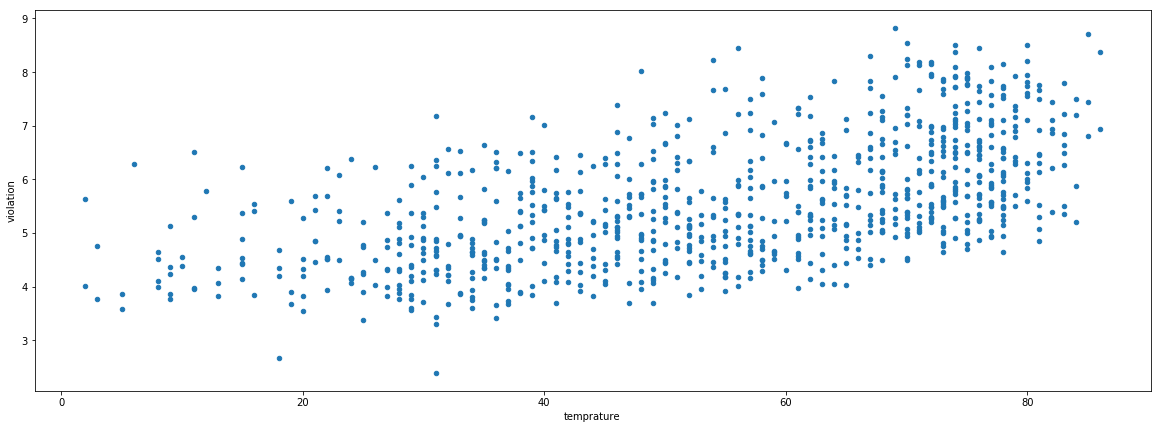

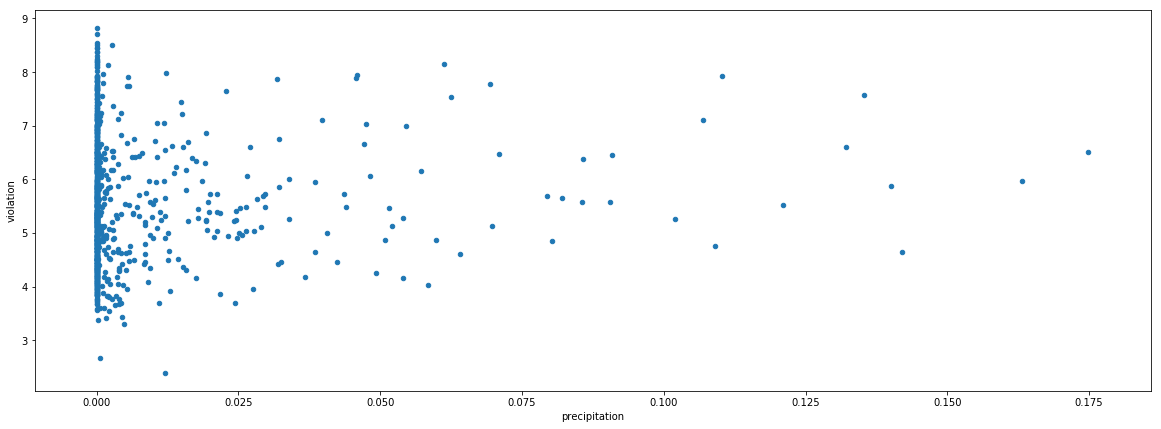

In [41]:
conn = sqlite3.connect('database.db')
c = conn.cursor()
print("Opened database successfully")
cursor = c.execute("select w.DATE, avg(violation), w.TEMPERATURE,w.PRECIPITATION from weather as w join \
violation as v on w.DATE=v.DATE where TEMPERATURE>=0 group by w.DATE order by w.TEMPERATURE;")
dates = []
violations = []
temps = []
precs = []
for row in cursor:
    dates.append(row[0])
    violations.append(float(row[1]))
    temps.append(round(row[2]))
    precs.append(float(row[3]))
print("Operation done successfully")
conn.close()

d={'date': dates, 'violation': violations,'temprature': temps,'precipitation': precs}
df=pd.DataFrame(data=d)


df.plot.scatter(x='temprature', y='violation',figsize=(20,7))
df.plot.scatter(x='precipitation', y='violation',figsize=(20,7))



## Statistical Analysis

#### We found that the relationship between temperature and average red light camera violation might be very close, as we see from the scatter plot, when temperature increases, the average violation seem to go up at the same time. So we run a regression, holding precipitation constant. 

Opened database successfully
Operation done successfully
         date  precipitation  temprature  violation
0  2014-07-01       0.140000   72.295745   5.879699
1  2014-07-02       0.002414   68.200000   5.862069
2  2014-07-03       0.005333   63.496667   6.687943
3  2014-07-04       0.000000   70.066667   6.614545
4  2014-07-05       0.000000   72.029167   6.334559


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              violation   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                     216.9
Date:                Wed, 29 Nov 2017   Prob (F-statistic):           8.78e-78
Time:                        20:15:08   Log-Likelihood:                -1242.8
No. Observations:                 914   AIC:                             2492.
Df Residuals:                     911   BIC:                             2506.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         3.7480      0.093     40.387      0.000       3.566       3.930
temprature        0.0340      0.002     20.711      0.000       0.031       0.037
precipitation    -3.6668      1.688     -2.172      0.030      -6.980      -0.354
==============================================================================
Omnibus:                       38.024   Durbin-Watson:                   0.445
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.875
Skew:                           0.447   Prob(JB):                     9.83e-09
Kurtosis:                       2.590   Cond. No.                     3.11e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.11e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

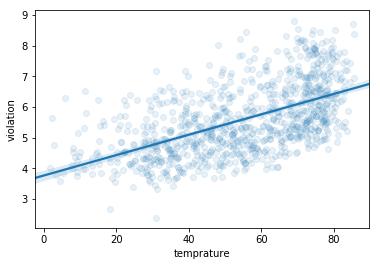

In [235]:
conn = sqlite3.connect('database.db')
c = conn.cursor()
print("Opened database successfully")
cursor = c.execute("select w.DATE, avg(violation), w.TEMPERATURE,w.PRECIPITATION from weather as w join \
violation as v on w.DATE=v.DATE where TEMPERATURE>=0 group by w.DATE order by w.DATE;")
dates = []
violations = []
temps = []
precs = []
for row in cursor:
    dates.append(row[0])
    violations.append(float(row[1]))
    temps.append(float(row[2]))
    precs.append(float(row[3]))
print("Operation done successfully")
conn.close()

d={'date': dates, 'violation': violations,'temprature': temps,'precipitation': precs}
df=pd.DataFrame(data=d)
print(df.head())

from scipy import stats
import statsmodels.formula.api as sm

import seaborn as sns

sns.regplot(x = "temprature", y = "violation", data = df, scatter_kws = {"alpha" : 0.1});

result = sm.ols(formula="violation~ temprature+ precipitation", data=df).fit()
result.summary()